# Na analysis (run 3575)

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

from invisible_cities.core.core_functions import timefunc, flat
from invisible_cities.reco.pmaps_functions import width, integrate_charge
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, save_to_folder 

from icaro.core.kdst_functions import load_dst, event_rate
DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Thu Apr  6 17:03:41 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [3]:
save = functools.partial(save_to_folder, outputfolder)

In [4]:
def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*f.values[1:], *reso(f.values)))



### Run

In [5]:
run_number = 3575

### Input data

In [6]:
# Comment out this line if your data is in $IC_DATA
#ifile = os.path.expandvars("/Users/Gonzalo/github/NEXTdata/Na22/Na22DST.h5")
ifile = os.path.join(os.environ['IC_DATA'],
                        'LSC/kdst/{}/kdst_3575_000_999.h5'.format(run_number))
print("ifile:", ifile)

ifile: /Users/jjgomezcadenas/Projects/ICDATA/LSC/kdst/3575/kdst_3575_000_999.h5


# Read data

In [7]:
full = load_dst(ifile)
full.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.491342e+09,0,1,275.0,64.295494,365.038980,486125.0,41.665438,9505.395508,...,654462.5,49.0,168.3375,168337.5,-30.902690,53.909130,62.138318,2.091304,41.113927,58.683844
1,4,1.491342e+09,0,1,200.0,36.470367,194.114036,531950.0,23.402500,9115.522461,...,661462.5,27.0,129.5125,129512.5,57.252296,0.689844,57.256452,0.012049,12.112382,52.490100
2,6,1.491342e+09,0,1,225.0,49.535275,273.186763,504150.0,30.916812,9145.306641,...,665462.5,43.0,161.3125,161312.5,-80.515359,8.131453,80.924926,3.040941,20.215411,13.245800
3,8,1.491342e+09,0,1,200.0,35.185417,195.103758,517600.0,29.096375,9989.318359,...,654862.5,22.0,137.2625,137262.5,72.665855,68.384014,99.783264,0.755051,13.088289,22.880939
4,12,1.491342e+09,0,1,175.0,34.424568,179.909183,617450.0,39.079687,20055.962891,...,656412.5,50.0,38.9625,38962.5,79.846011,-0.266283,79.846455,-0.003335,12.658441,19.831387


### Trigger rate and z distribution 

In [8]:
r = event_rate(full)

In [9]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 0.43752105359206156 evts/s


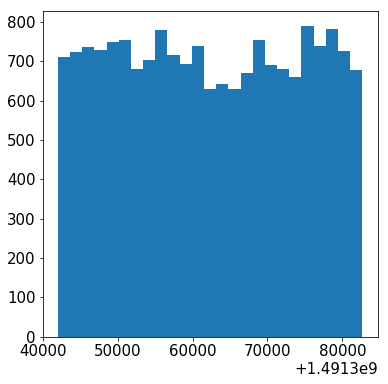

In [10]:
n, bins, patches  = hist(full.time, 25)

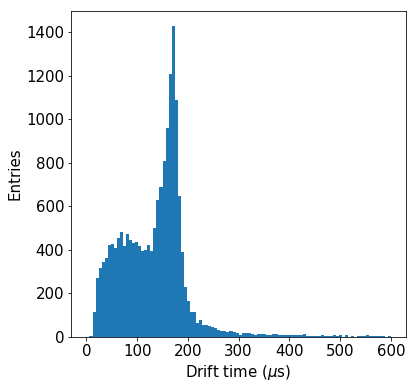

In [11]:
hist(full.Z/units.mus, 100, (0,600))
labels("Drift time ($\mu$s)", "Entries")

#### NB very visible position of the source

### Raw S2

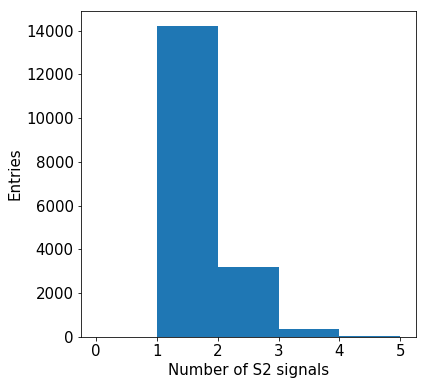

In [13]:
hist(full.nS2, 5, (0,5))
labels("Number of S2 signals", "Entries")

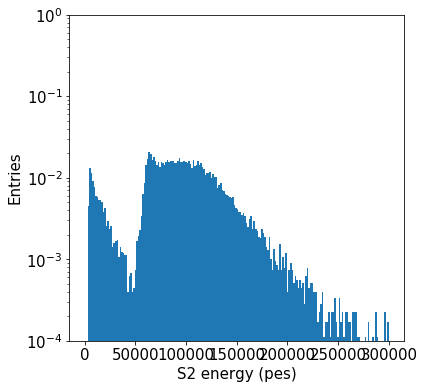

In [14]:
pdf(full.S2e, 200, (0,3e5))
labels("S2 energy (pes)", "Entries")

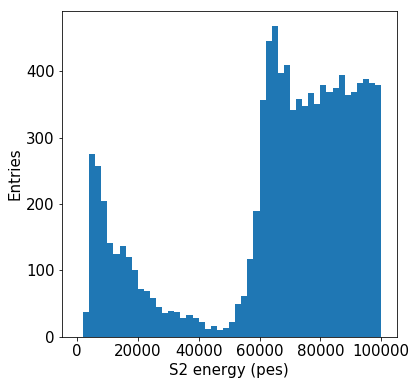

In [15]:
n, bins, patches  = hist(full.S2e, 50, (0e3,1e5))
labels("S2 energy (pes)", "Entries")

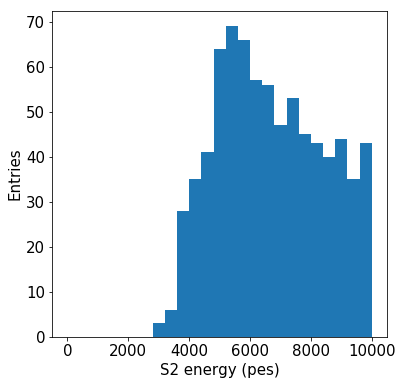

In [16]:
n, bins, patches  = hist(full.S2e, 25, (0,1e4))
labels("S2 energy (pes)", "Entries")

### S1

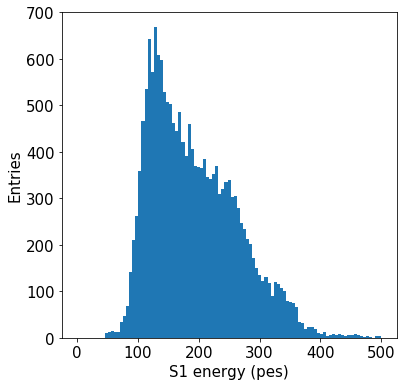

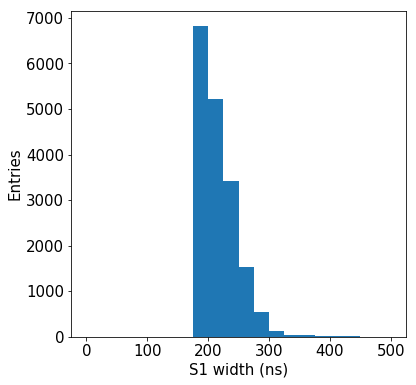

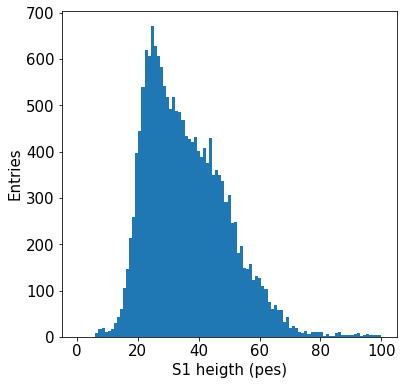

In [17]:
bins = np.linspace(0, 500, 100)
n, bins, patches  = hist(full.S1e, bins)
labels("S1 energy (pes)", "Entries")

bins = np.linspace(0, 500, 21)
n, bins, patches  = hist(full.S1w, bins)
labels("S1 width (ns)", "Entries")

bins = np.linspace(0, 100, 100)
n, bins, patches  =  hist(full.S1h, bins)
labels("S1 heigth (pes)", "Entries")

### S2 energy vs Z

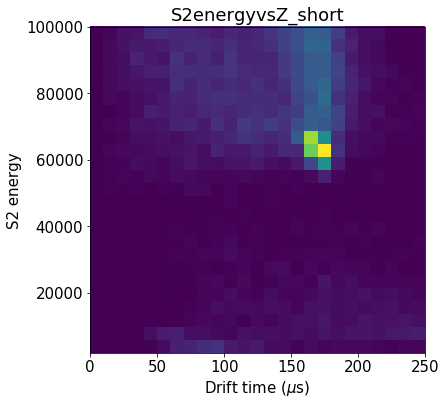

In [18]:
zrange =   0, 250
Erange = 2e3, 1e5
hist2d(full.Z/units.mus, full.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_short")

#zrange = 200, 600
#Erange = 2e3, 3e5
#hist2d(full.Z * 1e-3, full.S2e, (25,  25), range=(zrange, Erange))
#labels("Drift time ($\mu$s)", "S2 energy")
#save("S2energyvsZ_long")

### S1 energy vs Z

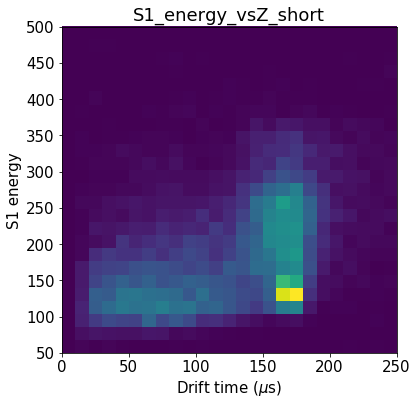

In [19]:
zrange =   0, 250
Erange = 50, 500
hist2d(full.Z/units.mus, full.S1e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S1 energy")
save("S1_energy_vsZ_short")

### S1 vs S2

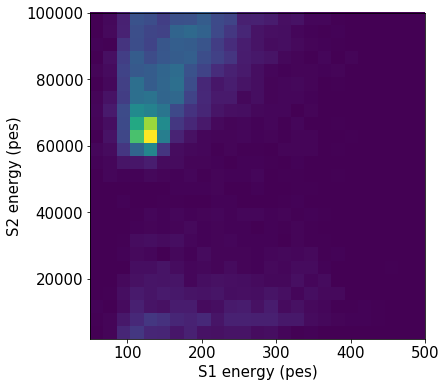

In [21]:
zrange =   0, 250
S1range = 50, 500
S2range = 2e3, 1e5
hist2d(full.S1e, full.S2e, (25, 25), range=(S1range, S2range))
labels("S1 energy (pes)", "S2 energy (pes)")
#save("S1_energy_vs_S2_energy_short")

# Short drift time: Z < 200 $\mu$s

In [22]:
zrange = 0, 200
shortZ = full[full.Z/units.mus < 200]
print("Ratio:", len(shortZ)/len(full))
shortZ.head()

Ratio: 0.9254260165345031


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.491342e+09,0,1,275.0,64.295494,365.038980,486125.0,41.665438,9505.395508,...,654462.5,49.0,168.3375,168337.5,-30.902690,53.909130,62.138318,2.091304,41.113927,58.683844
1,4,1.491342e+09,0,1,200.0,36.470367,194.114036,531950.0,23.402500,9115.522461,...,661462.5,27.0,129.5125,129512.5,57.252296,0.689844,57.256452,0.012049,12.112382,52.490100
2,6,1.491342e+09,0,1,225.0,49.535275,273.186763,504150.0,30.916812,9145.306641,...,665462.5,43.0,161.3125,161312.5,-80.515359,8.131453,80.924926,3.040941,20.215411,13.245800
3,8,1.491342e+09,0,1,200.0,35.185417,195.103758,517600.0,29.096375,9989.318359,...,654862.5,22.0,137.2625,137262.5,72.665855,68.384014,99.783264,0.755051,13.088289,22.880939
4,12,1.491342e+09,0,1,175.0,34.424568,179.909183,617450.0,39.079687,20055.962891,...,656412.5,50.0,38.9625,38962.5,79.846011,-0.266283,79.846455,-0.003335,12.658441,19.831387


# S2 energy

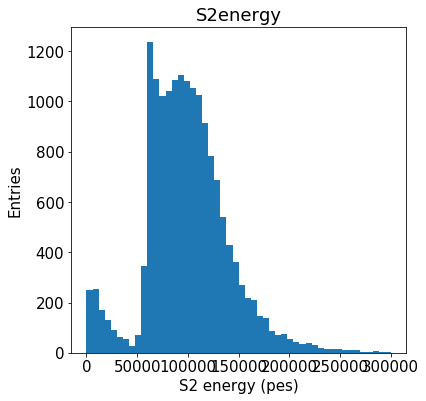

In [23]:
Erange = 0e3, 300e3

hist(shortZ.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy")


In [ ]:
def profile_histogram()

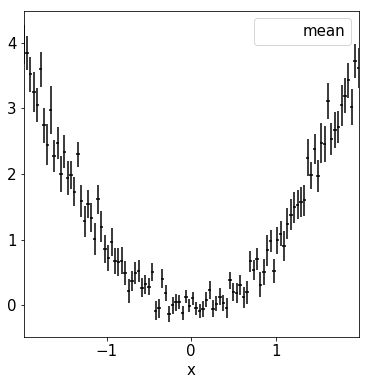

In [25]:

# just some random numbers to get startet
x = np.random.uniform(-2, 2, 10000)
y = np.random.normal(x**2, np.abs(x) + 1)
df = pd.DataFrame({'x': x, 'y': y})


# calculate in which bin row belongs base on `x`
# bins needs the bin edges, so this will give as 100 equally sized bins
bins = np.linspace(-2, 2, 101)
df['bin'] = np.digitize(x, bins=bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_width = bins[1] - bins[0]

# grouby bin, so we can calculate stuff
binned = df.groupby('bin')
# calculate mean and standard error of the mean for y in each bin
result = binned['y'].agg(['mean', 'sem'])
result['x'] = bin_centers
result['xerr'] = bin_width / 2

# plot it

result.plot(
    x='x',
    y='mean',
    xerr='xerr',
    yerr='sem',
    linestyle='none',
    capsize=0,
    color='black',
)
#plt.savefig('result.png', dpi=300)

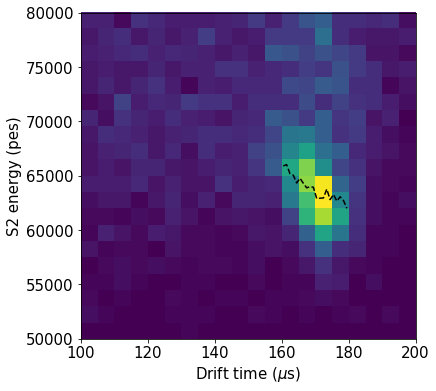

In [24]:
Erange = 50e3, 80e3
zrange = 100, 200
pErange = 55e3, 70e3
pZrange = 160, 180

hist2d(shortZ.Z/units.mus, shortZ.S2e, (20, 20), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z/units.mus, shortZ.S2e, 20, xrange=pZrange, yrange=pErange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
#save("S2energyvsZ")

# S2 width

In [ ]:
zrange = 0, 200
wrange = 5, 15

hist(shortZ.S2w, 20)
labels("S2 width ($\mu$s)", "Entries")
#save("S2width")

#hist2d(shortZ.Z, shortZ.S2w*1e-3, (50, 20), range=(zrange, wrange))
#x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2w*1e-3, 30, xrange=zrange, yrange=wrange)
#plt.plot(x, y, profOpt)

#labels("Drift time ($\mu$s)", "S2 energy (pes)")
#save("S2widthvsZ")

# S2 height

In [ ]:
zrange = 0, 200
hrange = 0, 40e3

hist(shortZ.S2h, 30, range=hrange)
labels("S2 height (pes)", "Entries")
#save("S2height")

#hist2d(shortZ.Z, shortZ.S2h, (50, 30), range=(zrange, hrange))
#x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2h, 30, xrange=zrange, yrange=hrange)
#plt.plot(x, y, profOpt)

#labels("Drift time ($\mu$s)", "S2 height (pes)")
#save("S2heightvsZ")

# S2 peak to area ratio

In [ ]:
zrange = 0, 200
rrange = 0, 0.5

S2r = shortZ.S2h/shortZ.S2e

hist(S2r, 50, range=rrange)
labels("Height/Area", "Entries")
#save("S2Peak2Area")

#hist2d(shortZ.Z, S2r, (50, 50), range=(zrange, rrange))
#x, y, _ = fitf.profileX(shortZ.Z, S2r, 30, xrange=zrange, yrange=rrange)
#plt.plot(x, y, profOpt)

#labels("Drift time ($\mu$s)", "Height/Area")
#save("S2ratiovsZ")

# S2 vs S1

In [ ]:
Srange = 0, 20
Erange = 0, 3e5

S = shortZ.S1e
E = shortZ.S2e

hist2d(S, E, (50, 50), range=(Srange, Erange))
x, y, _ = fitf.profileX(S, E, 30, xrange=Srange, yrange=Erange)
plt.plot(x, y, profOpt)

sel = fitf.in_range(S, *Srange) & fitf.in_range(E, *Erange)
c = covariance(S[sel], E[sel])
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

In [ ]:
zrange = 0, 200
Rrange = 0, 0.006

S12r = shortZ.S1e/shortZ.S2e

hist(S12r, 50, range=Rrange)
labels("S1/S2", "Entries")
save("S12ratio")

hist2d(shortZ.Z, S12r, (50, 50), range=(zrange, Rrange))
x, y, _ = fitf.profileX(shortZ.Z, S12r, 30, xrange=zrange, yrange=Rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2")
save("S12ratiovsZ")

# Temporary fiducialization

In [ ]:
shortZfid = shortZ[shortZ.R < 100]
print("Ratio:", len(shortZfid)/len(full))
print("Ratio:", len(shortZfid)/len(shortZ))
shortZfid.head()

# S2 energy fiducialized

In [ ]:
zrange = 0,200
Erange = 0e3, 200e3

hist(shortZfid.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
#save("S2energy_fiducial")



In [ ]:
Erange = 50e3, 80e3
zrange = 100, 200
pErange = 55e3, 70e3
pZrange = 160, 180

hist2d(shortZ.Z/units.mus, shortZ.S2e, (20, 20), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z/units.mus, shortZ.S2e, 20, xrange=pZrange, yrange=pErange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")

In [ ]:
sel  = fitf.in_range(x, 160, 180)
x, y = x[sel], y[sel]

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
#save("S2energyvsZ_fiducial")

zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

# Correction by attachment

In [ ]:
Erange = 1e3, 200e3
E = shortZfid.S2e * zcorr(shortZfid.Z/units.mus)
y, x, _ = hist(E, 50, range=Erange)

In [ ]:
Erange = 50e3, 100e3
E = shortZfid.S2e * zcorr(shortZfid.Z/units.mus)
y, x, _ = hist(E, 25, range=Erange)

In [ ]:
x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 65e3, 75e3)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 7e4, 2000))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("S2 energy (pes)", "Entries")

In [ ]:
Erange = 50e3, 100e3
E = shortZfid.S2e * zcorr(shortZfid.Z/units.mus)

y, x, _ = hist(E, 50, range=Erange)

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 62e3, 72e3)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 7e4, 2000))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("S2 energy (pes)", "Entries")



In [ ]:
Erange2 = 140e3, 170e3

# Tracking

In [ ]:
nrange = 0, 12
zrange = 0, 600

hist(shortZ.Nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")
save("Nsipm")

hist2d(shortZ.Z/units.mus, shortZ.Nsipm, (30, max(nrange)), range=(zrange, nrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.Nsipm, 30, xrange=zrange, yrange=nrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs")
#save("NsipmvsZ")


# Event distribution

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(shortZ.X, 50, range=xrange)
labels("x (mm)", "Entries")
save("X")

hist(shortZ.Y, 50, range=yrange)
labels("y (mm)", "Entries")
save("Y")

hist(shortZ.R, 50, range=rrange)
labels("r (mm)", "Entries")
save("R")

hist(shortZ.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")
save("Phi")

nevts, xs, ys, _ = \
hist2d(shortZ.X, shortZ.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

################################
hist2d(shortZ.R, shortZ.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

# Tracking charge

In [ ]:
zrange = 0, 200
Qrange = 0, 500

hist(shortZ.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries")
save("S2charge")

hist2d(shortZ.Z, shortZ.S2q, (50, 100), range=(zrange, Qrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2q, 30, xrange=zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)")
save("S2chargevsZ")

In [ ]:
xrange = -215, 215
yrange = -50, 50
rrange =    0, 215
prange = - pi,  pi
Qrange =    0, 500

_, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, shortZ.S2q, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, shortZ.S2q, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

hist2d(shortZ.R, shortZ.S2q, (50, 50), range=(rrange, Qrange))
x, y, _ = fitf.profileX(shortZ.R, shortZ.S2q, 50, xrange=rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

hist2d(shortZ.Phi, shortZ.S2q, (50, 50), range=(prange, Qrange))
x, y, _ = fitf.profileX(shortZ.Phi, shortZ.S2q, 50, xrange=prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)")
save("QvsPhi")


# Energy vs position

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E = shortZ.S2e * zcorr(shortZ.Z)

pf, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(shortZ.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(shortZ.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])


# Correction by attachment and position

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 11e3

E  = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values)

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(shortZ.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(shortZ.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


In [ ]:
E = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values)
T = (shortZ.time - np.min(shortZ.time))/60

Erange = 4e3, 11e3
Trange =   0, 1800

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

def get_timecorr(T, E):
    eref = np.max(E)
    def timecorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return timecorr
tcorr = get_timecorr(x, y)

In [ ]:
T = (shortZ.time - np.min(shortZ.time))/60
E = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values) * tcorr(T)

Trange =   0, 1800
Erange = 4e3, 11e3

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXYT")

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")
